In [1]:
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import numpy as np
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from utils.generators import UserGenerator

In [5]:
ug = UserGenerator()

In [49]:
# Automate the process from part 1

def calculate_posterior(ug, n_samples , initial_rate, lift,user_ratio=0.5, return_trace=False ):
    nr_of_days = 1
    hour_split = int((nr_of_days*24) * user_ratio )
    
    # create dataset
    dat = ug.generate_lift_data(n_samples,initial_rate,lift,nr_of_days, user_ratio=user_ratio)
    
    
    # parse_time
    dat['hour'] = dat.datetime.dt.hour
    dat = dat.reset_index()[['user_id','datetime','purchased','hour']]
    #return dat
    # sample it
    trace_sampled = run_sampler(dat)
    
    tau_post = trace_sampled['tau'][:5000]
    
    dat_time = dat[['hour']]
    dat_time['posterior_split'] = dat_time.index.to_series().map(Counter(tau_post))
    
    time_split = dat_time.groupby('hour')['posterior_split'].sum()
    lambda_1_trace = trace_sampled['lambda_1'] * dat.shape[0]
    lambda_2_trace = trace_sampled['lambda_2'] * dat.shape[0]
    
    # accuracy for time prediction
    #try:
    #    print("timecalc", hour_split, time_split[hour_split],  time_split.sum())
    #except:
    #    print(time_split)
    
    if hour_split in time_split:
        time_accuracy = time_split[hour_split] / time_split.sum()
    else:
        time_accuracy = 0
    
    if return_trace:
        return trace_sampled, time_split, hour_split
    
    return lambda_1_trace, lambda_2_trace, time_accuracy,time_split
    # return accuracy
    

def run_sampler(dat):
    
    with pm.Model() as model:
    
        lambda_1 = pm.Uniform("lambda_1",  lower=0, upper=1)
        lambda_2 = pm.Uniform("lambda_2",  lower=0, upper=1)
    
        tau = pm.DiscreteUniform("tau", lower=0, upper=dat.shape[0] - 1)
    
        # to be able to tell the index point of change we need to add an index
        index = np.arange(dat.shape[0])
    
        # a switch to find the point of interest
        lambda_ = pm.math.switch(tau > index, lambda_1, lambda_2)
    
        observation = pm.Binomial("obs", p=lambda_, n=dat.shape[0], observed=dat.purchased)

        # initializer 
        start = pm.find_MAP()
        # NUTS sampler
        step = pm.NUTS(target_accept=0.95)
        trace = pm.sample(5000, tune=2000,step=step, discard_tuned_samples=True, cores=4)
        
        
    return trace[2000:] # return burned trace
    

In [60]:
repetitions = 10
user_numbers = [50,100,200, 500, 1000, 5000,10000]
lift_detection = {}
dataframe = pd.DataFrame()
for rep in range(repetitions):
    for n_users in user_numbers:
        lift_detection = {}
        for lift in np.linspace(0.05,0.5,num=10):
        
            base_p = 0.1
            
            print(n_users, rep)
    
            lambda_1, lambda_2, time_accuracy,time_series = calculate_posterior(ug, 
                                                                                n_users, 
                                                                                base_p , 
                                                                                lift, 
                                                                                user_ratio=0.22 )
        
        
            lift_detection[f'{n_users}-{np.round(lift,2)}-{rep}'] = {'lift':lift,
                                'l1':lambda_1.mean(), 
                                'l2':lambda_2.mean(), 
                                "time_accuracy":time_accuracy,
                                'user':n_users,
                                "time_series":time_series}
        
        
        dat = pd.DataFrame.from_dict(lift_detection, orient='index')

        dataframe = dataframe.append(dat)
        print(dataframe.shape[0])

INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


50 0


logp = -27.931, ||grad|| = 0.041061: 100%|██████████| 15/15 [00:00<00:00, 4420.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 608 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3938.19draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8021453362692567, but should be close to 0.95. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8551708629600543, but should be close to 0.95. Try to increase the number of tuning steps.
There were 390 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.643252866908904, but should be close to 0.95. Try to increase the number of tuning steps.
Th

50 0


logp = -24.548, ||grad|| = 0.054862: 100%|██████████| 15/15 [00:00<00:00, 3939.05it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,425 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4332.18draws/s]
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8054666642256577, but should be close to 0.95. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7532237848571433, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3653165670822992, but should be close to 0.95. Try to increase the number of tuning steps

50 0


logp = -34.149, ||grad|| = 0.008022: 100%|██████████| 14/14 [00:00<00:00, 3259.52it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 722 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3534.72draws/s]
There were 522 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6585429141434949, but should be close to 0.95. Try to increase the number of tuning steps.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7408598395396683, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-package

50 0


logp = -35.619, ||grad|| = 0.0038272: 100%|██████████| 14/14 [00:00<00:00, 4577.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 717 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4317.65draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8315753924426601, but should be close to 0.95. Try to increase the number of tuning steps.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8273431116373278, but should be close to 0.95. Try to increase the number of tuning steps.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7504639493057549, but should be close to 0.95. Try to increase the number of tuning steps.


50 0


logp = -26.554, ||grad|| = 0.030132: 100%|██████████| 14/14 [00:00<00:00, 4344.18it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 202 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3221.87draws/s]
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8212567312405445, but should be close to 0.95. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8408752829091238, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages

50 0


logp = -35.488, ||grad|| = 0.028479: 100%|██████████| 15/15 [00:00<00:00, 3785.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3244.79draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


50 0


logp = -37.018, ||grad|| = 0.045214: 100%|██████████| 15/15 [00:00<00:00, 4245.82it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3714.69draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


50 0


logp = -47.119, ||grad|| = 0.001553: 100%|██████████| 13/13 [00:00<00:00, 4286.97it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,572 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3698.58draws/s]
There were 296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6724744145836886, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1276 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43688738941518734, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-pac

50 0


logp = -43.848, ||grad|| = 0.00019974: 100%|██████████| 13/13 [00:00<00:00, 4359.29it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,979 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3512.03draws/s]
There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8611953963227083, but should be close to 0.95. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8593327317800796, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1246 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5020058081511899, but should be close to 0.95. Try to increase the number of tuning ste

50 0


logp = -47.119, ||grad|| = 0.001553: 100%|██████████| 13/13 [00:00<00:00, 3057.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 111 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3528.89draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8719255992280339, but should be close to 0.95. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

10
100 0


logp = -48.024, ||grad|| = 0.67719: 100%|██████████| 16/16 [00:00<00:00, 3924.49it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,334 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3516.04draws/s]
The acceptance probability does not match the target. It is 0.7785298499966732, but should be close to 0.95. Try to increase the number of tuning steps.
There were 117 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8582989786035615, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5942899015035872, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight 

100 0


logp = -64.502, ||grad|| = 0.33131: 100%|██████████| 16/16 [00:00<00:00, 4447.24it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 988 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3763.72draws/s]
There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5115468083718047, but should be close to 0.95. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8971865938656763, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7916114656704533, but should be close to 0.95. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
T

100 0


logp = -61.245, ||grad|| = 0.31304: 100%|██████████| 15/15 [00:00<00:00, 4228.13it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,209 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3427.74draws/s]
There were 2122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23158551920105275, but should be close to 0.95. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.878342897931684, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8770223569430051, but should be close to 0.95. Try to increase the number of tuning steps.
Th

100 0


logp = -66.551, ||grad|| = 0.23429: 100%|██████████| 15/15 [00:00<00:00, 4600.36it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 724 divergences: 100%|██████████| 28000/28000 [00:11<00:00, 2443.39draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 700 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5922743767697349, but should be close to 0.95. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

100 0


logp = -64.502, ||grad|| = 0.33131: 100%|██████████| 16/16 [00:00<00:00, 4757.47it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 194 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3583.58draws/s]
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8137027080324851, but should be close to 0.95. Try to increase the number of tuning steps.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8859188940394653, but should be close to 0.95. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8372851673778992, but should be close to 0.95. Try to increase the number of tuning steps.
The

100 0


logp = -72.563, ||grad|| = 0.15101: 100%|██████████| 15/15 [00:00<00:00, 4425.30it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,986 divergences:  65%|██████▌   | 18247/28000 [00:04<00:03, 2765.49draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains, 4,950 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2694.11draws/s]
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8011728227290354, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3456 divergences after tuning. Increase `t

100 0


logp = -81.413, ||grad|| = 0.11583: 100%|██████████| 15/15 [00:00<00:00, 4308.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 21 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3310.86draws/s]
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8631758156713749, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

100 0


logp = -78.158, ||grad|| = 0.115: 100%|██████████| 15/15 [00:00<00:00, 3883.14it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 20 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4129.09draws/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


100 0


logp = -87.399, ||grad|| = 0.041937: 100%|██████████| 14/14 [00:00<00:00, 3575.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,929 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3829.77draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8815015106824533, but should be close to 0.95. Try to increase the number of tuning steps.
There were 405 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4296987890364267, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069219099965495, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1517 divergences after tuning. Increase `target_accept` or reparameterize

100 0


logp = -83.361, ||grad|| = 0.05377: 100%|██████████| 14/14 [00:00<00:00, 3877.20it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 795 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2870.50draws/s]
There were 318 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7427600218079992, but should be close to 0.95. Try to increase the number of tuning steps.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8281042879474583, but should be close to 0.95. Try to increase the number of tuning steps.
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.75698609837849, but should be close to 0.95. Try to increase the number of tuning steps.
Th

20
200 0


logp = -91.144, ||grad|| = 5.9395: 100%|██████████| 17/17 [00:00<00:00, 3828.77it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 10 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4046.24draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

200 0


logp = -90.664, ||grad|| = 6.0602: 100%|██████████| 17/17 [00:00<00:00, 4181.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,240 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 3032.41draws/s]
There were 725 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.29696081020757403, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 514 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215041540669059, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8482320779704691, but should be close to 0.95. Try to increase the number of tuning steps.
Th

200 0


logp = -107.21, ||grad|| = 4.8902: 100%|██████████| 17/17 [00:00<00:00, 4708.97it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2994.36draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 0


logp = -132.59, ||grad|| = 2.9705: 100%|██████████| 16/16 [00:00<00:00, 4073.87it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 632 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3538.74draws/s]
There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6682465217059009, but should be close to 0.95. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8030755222274139, but should be close to 0.95. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8599841902529904, but should be close to 0.95. Try to increase the number of tuning steps.
Th

200 0


logp = -134.44, ||grad|| = 2.9614: 100%|██████████| 16/16 [00:00<00:00, 4138.18it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 66 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4584.13draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5635306540616303, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

200 0


logp = -135.13, ||grad|| = 3.1707: 100%|██████████| 16/16 [00:00<00:00, 4012.01it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 291 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4155.77draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7831382254369079, but should be close to 0.95. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8271837454549089, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is sma

200 0


logp = -145.38, ||grad|| = 2.4128: 100%|██████████| 16/16 [00:00<00:00, 3903.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 33 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4319.46draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

200 0


logp = -164.82, ||grad|| = 1.4728: 100%|██████████| 15/15 [00:00<00:00, 4106.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 40 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4519.24draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8602165815949326, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-

200 0


logp = -167.41, ||grad|| = 1.3413: 100%|██████████| 15/15 [00:00<00:00, 3604.39it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 31 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3981.55draws/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.883109677820406, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

200 0


logp = -172.48, ||grad|| = 1.0861: 100%|██████████| 15/15 [00:00<00:00, 3939.79it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 8 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4514.77draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubunt

30
500 0


logp = -211.61, ||grad|| = 62.271: 100%|██████████| 19/19 [00:00<00:00, 4316.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 147 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2798.26draws/s]
There were 147 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4772273911439172, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

500 0


logp = -284.84, ||grad|| = 51.316: 100%|██████████| 18/18 [00:00<00:00, 3780.54it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,788 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3887.77draws/s]
There were 1668 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5262823543604341, but should be close to 0.95. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8706208048301811, but should be close to 0.95. Try to increase the number of tuning steps.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6816593207444132, but should be close to 0.95. Try to increase the number of tuning steps.


500 0


logp = -298.43, ||grad|| = 49.222: 100%|██████████| 17/17 [00:00<00:00, 4047.18it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 186 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3554.85draws/s]
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8668112075607415, but should be close to 0.95. Try to increase the number of tuning steps.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8956763595035855, but should be close to 0.95. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8707069845717781, but should be close to 0.95. Try to increase the number of tuning steps.
The 

500 0


logp = -332, ||grad|| = 44.25: 100%|██████████| 17/17 [00:00<00:00, 4010.30it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4274.54draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 0


logp = -329.38, ||grad|| = 44.818: 100%|██████████| 18/18 [00:00<00:00, 3522.82it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4269.53draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 0


logp = -350.92, ||grad|| = 41.264: 100%|██████████| 17/17 [00:00<00:00, 3495.42it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4477.56draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


500 0


logp = -384.88, ||grad|| = 36.285: 100%|██████████| 17/17 [00:00<00:00, 3945.29it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4315.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 0


logp = -395.24, ||grad|| = 34.409: 100%|██████████| 17/17 [00:00<00:00, 4181.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4378.92draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 0


logp = -414.09, ||grad|| = 31.186: 100%|██████████| 17/17 [00:00<00:00, 4121.57it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4353.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


500 0


logp = -427.68, ||grad|| = 28.891: 100%|██████████| 16/16 [00:00<00:00, 4250.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4327.18draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


40
1000 0


logp = -614.75, ||grad|| = 265.9: 100%|██████████| 19/19 [00:00<00:00, 2743.07it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 862 divergences: 100%|██████████| 28000/28000 [00:13<00:00, 2101.02draws/s]
There were 861 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2523061490600642, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8261038926789805, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipyke

1000 0


logp = -652.84, ||grad|| = 256.82: 100%|██████████| 19/19 [00:00<00:00, 2754.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 12 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3644.54draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8810086533277767, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lo

1000 0


logp = -690.38, ||grad|| = 247.58: 100%|██████████| 19/19 [00:00<00:00, 3644.22it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3879.48draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 0


logp = -728.9, ||grad|| = 237.74: 100%|██████████| 18/18 [00:00<00:00, 3402.32it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3782.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 0


logp = -778.22, ||grad|| = 224.48: 100%|██████████| 18/18 [00:00<00:00, 3617.17it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3812.20draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 0


logp = -808.52, ||grad|| = 215.8: 100%|██████████| 18/18 [00:00<00:00, 3438.58it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3846.44draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 0


logp = -820.78, ||grad|| = 212.24: 100%|██████████| 18/18 [00:00<00:00, 3270.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3779.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 0


logp = -848.97, ||grad|| = 203.39: 100%|██████████| 18/18 [00:00<00:00, 3790.41it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3844.45draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 0


logp = -874.21, ||grad|| = 195.43: 100%|██████████| 18/18 [00:00<00:00, 3930.32it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3800.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 0


logp = -881.75, ||grad|| = 192.05: 100%|██████████| 19/19 [00:00<00:00, 3977.63it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3712.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


50
5000 0


logp = -10,641, ||grad|| = 7,422.8: 100%|██████████| 21/21 [00:00<00:00, 2015.66it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1875.94draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 0


logp = -10,573, ||grad|| = 7,348.7: 100%|██████████| 21/21 [00:00<00:00, 2637.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1985.30draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 0


logp = -10,540, ||grad|| = 7,315.8: 100%|██████████| 21/21 [00:00<00:00, 2725.68it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1903.99draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 0


logp = -10,469, ||grad|| = 7,247.4: 100%|██████████| 21/21 [00:00<00:00, 2541.34it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1969.84draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 0


logp = -10,392, ||grad|| = 7,178.8: 100%|██████████| 20/20 [00:00<00:00, 2529.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1945.08draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 0


logp = -10,347, ||grad|| = 7,145.1: 100%|██████████| 20/20 [00:00<00:00, 2441.46it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:13<00:00, 2000.94draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 0


logp = -10,274, ||grad|| = 7,086.3: 100%|██████████| 20/20 [00:00<00:00, 1868.70it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1954.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 0


logp = -10,197, ||grad|| = 7,029.7: 100%|██████████| 20/20 [00:00<00:00, 1905.42it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1920.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 0


logp = -10,127, ||grad|| = 6,980.6: 100%|██████████| 20/20 [00:00<00:00, 2339.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1913.93draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 0


logp = -10,032, ||grad|| = 6,920.2: 100%|██████████| 20/20 [00:00<00:00, 2693.75it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1921.03draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


60
50 1


logp = -8.1702, ||grad|| = 0.0031024: 100%|██████████| 30/30 [00:00<00:00, 4668.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:05<00:00, 4746.52draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9074584195387859, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

50 1


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -32.911, ||grad|| = 0.0083677: 100%|██████████| 14/14 [00:00<00:00, 3775.25it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 640 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4065.34draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8920473355757819, but should be close to 0.95. Try to increase the number of tuning steps.
There were 470 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6749180175250346, but should be close to 0.95. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparame

50 1


logp = -27.931, ||grad|| = 0.041061: 100%|██████████| 15/15 [00:00<00:00, 3011.71it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 115 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4273.51draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8550649642426629, but should be close to 0.95. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8571135298252162, but should be close to 0.95. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8686839990949321, but should be close to 0.95. Try to increase the number of tuning steps.
Th

50 1


logp = -27.69, ||grad|| = 0.050711: 100%|██████████| 15/15 [00:00<00:00, 4274.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 501 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4290.64draws/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8209212190966909, but should be close to 0.95. Try to increase the number of tuning steps.
There were 162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8750009341415638, but should be close to 0.95. Try to increase the number of tuning steps.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6594440

50 1


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -32.477, ||grad|| = 0.018246: 100%|██████████| 15/15 [00:00<00:00, 4236.96it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,515 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3386.84draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 1325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47123139391985003, but should be close to 0.95. Try to increase the number of tuning steps.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8485873799766771, but should be close to 0.95. Try to increase the number of tunin

50 1


logp = -41.462, ||grad|| = 0.002762: 100%|██████████| 14/14 [00:00<00:00, 4156.89it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 61 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3472.88draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8640692356229877, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

50 1


logp = -39.033, ||grad|| = 0.0017215: 100%|██████████| 14/14 [00:00<00:00, 4124.19it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,946 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3146.37draws/s]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.78781020920423, but should be close to 0.95. Try to increase the number of tuning steps.
There were 458 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6425155502620677, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1330 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3917932988610221, but should be close to 0.95. Try to increase the number of tuning step

50 1


logp = -42.68, ||grad|| = 0.0071635: 100%|██████████| 14/14 [00:00<00:00, 4087.16it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 560 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3630.08draws/s]
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7467605179347935, but should be close to 0.95. Try to increase the number of tuning steps.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.66316628770922, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/

50 1


logp = -44.343, ||grad|| = 0.0042287: 100%|██████████| 14/14 [00:00<00:00, 3863.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,216 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2984.29draws/s]
There were 556 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5941477874338693, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1660 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31552420199181386, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-pa

50 1


logp = -47.515, ||grad|| = 0.00021211: 100%|██████████| 13/13 [00:00<00:00, 3935.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 560 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2862.31draws/s]
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7787496217875726, but should be close to 0.95. Try to increase the number of tuning steps.
There were 475 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6965257769519491, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

70
100 1


logp = -48.93, ||grad|| = 0.79389: 100%|██████████| 17/17 [00:00<00:00, 4213.39it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 23 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3763.32draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8960804328004999, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be

100 1


logp = -39.637, ||grad|| = 1.0821: 100%|██████████| 17/17 [00:00<00:00, 3936.57it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 837 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3898.22draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9036695725881524, but should be close to 0.95. Try to increase the number of tuning steps.
There were 836 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6287105645411609, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipyk

100 1


logp = -57.861, ||grad|| = 0.43559: 100%|██████████| 15/15 [00:00<00:00, 3338.17it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,715 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3497.92draws/s]
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7984247128891572, but should be close to 0.95. Try to increase the number of tuning steps.
There were 829 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5314618991424224, but should be close to 0.95. Try to increase the number of tuning steps.
There were 787 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6460299230129029, but should be close to 0.95. Try to increase the number of tuning steps.

100 1


logp = -59.608, ||grad|| = 0.36685: 100%|██████████| 15/15 [00:00<00:00, 4022.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,069 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3938.53draws/s]
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 631 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6166898488248351, but should be close to 0.95. Try to increase the number of tuning steps.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7450735816036697, but should be close to 0.95. Try to increase the number of tuning steps.
There were 984 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.55675

100 1


logp = -76.212, ||grad|| = 0.093137: 100%|██████████| 14/14 [00:00<00:00, 3927.25it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 587 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3505.83draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 508 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6115548575418321, but should be close to 0.95. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.824928837793693, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is sm

100 1


logp = -72.839, ||grad|| = 0.13217: 100%|██████████| 15/15 [00:00<00:00, 4026.27it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 408 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 3089.77draws/s]
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8516593696870572, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7854272706515731, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is sm

100 1


logp = -73.924, ||grad|| = 0.17357: 100%|██████████| 15/15 [00:00<00:00, 3238.51it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 832 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2607.31draws/s]
There were 192 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8457127826212659, but should be close to 0.95. Try to increase the number of tuning steps.
There were 640 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6207615978073107, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827654359238912, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of ef

100 1


logp = -85.311, ||grad|| = 0.05129: 100%|██████████| 14/14 [00:00<00:00, 4005.75it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 5 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3817.69draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100 1


logp = -85.887, ||grad|| = 0.051127: 100%|██████████| 14/14 [00:00<00:00, 4203.61it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,503 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3715.95draws/s]
There were 963 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5600742190742003, but should be close to 0.95. Try to increase the number of tuning steps.
There were 540 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6580909376045012, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packa

100 1


logp = -92.229, ||grad|| = 0.02351: 100%|██████████| 14/14 [00:00<00:00, 3980.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3795.26draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


80
200 1


logp = -90.987, ||grad|| = 5.9761: 100%|██████████| 17/17 [00:00<00:00, 4243.73it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 38 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4231.97draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8632243165083356, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site

200 1


logp = -110.08, ||grad|| = 4.4551: 100%|██████████| 16/16 [00:00<00:00, 3356.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 394 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2939.52draws/s]
There were 393 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7503917581871495, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

200 1


logp = -125.14, ||grad|| = 3.5904: 100%|██████████| 16/16 [00:00<00:00, 4084.04it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,972 divergences:  57%|█████▋    | 15947/28000 [00:04<00:03, 3122.38draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains, 4,164 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3266.76draws/s]
There were 3579 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.018347355231374766, but should be close to 0.95. Try to increase the number of tuning steps.
There were 585 divergences after tuning. Increase `

200 1


logp = -131.31, ||grad|| = 3.0509: 100%|██████████| 16/16 [00:00<00:00, 3780.36it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,201 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2976.92draws/s]
There were 894 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6384732294445715, but should be close to 0.95. Try to increase the number of tuning steps.
There were 304 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8125585518550801, but should be close to 0.95. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is s

200 1


logp = -131.06, ||grad|| = 3.1065: 100%|██████████| 16/16 [00:00<00:00, 3853.29it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 43 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4180.45draws/s]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lo

200 1


logp = -148.45, ||grad|| = 2.4916: 100%|██████████| 17/17 [00:00<00:00, 3756.55it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4352.71draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 1


logp = -166.78, ||grad|| = 1.3548: 100%|██████████| 15/15 [00:00<00:00, 3628.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:05<00:00, 4853.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 1


logp = -152.85, ||grad|| = 2.0954: 100%|██████████| 16/16 [00:00<00:00, 3253.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 344 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4375.30draws/s]
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8029663331339482, but should be close to 0.95. Try to increase the number of tuning steps.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8090541698840538, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9015940250242421, but should be close to 0.95. Try to increase the number of tuning steps.
There

200 1


logp = -162.4, ||grad|| = 1.7224: 100%|██████████| 16/16 [00:00<00:00, 3972.58it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4509.36draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 1


logp = -163.38, ||grad|| = 1.5934: 100%|██████████| 15/15 [00:00<00:00, 3979.16it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4662.13draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


90
500 1


logp = -247.4, ||grad|| = 56.932: 100%|██████████| 18/18 [00:00<00:00, 4193.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:11<00:00, 2475.16draws/s]
The acceptance probability does not match the target. It is 0.882518433137177, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8393942599609031, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

500 1


logp = -281.97, ||grad|| = 51.764: 100%|██████████| 18/18 [00:00<00:00, 4163.54it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,417 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2841.82draws/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1405 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5542016560366994, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

500 1


logp = -273.33, ||grad|| = 53.408: 100%|██████████| 19/19 [00:00<00:00, 4061.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4291.36draws/s]
The acceptance probability does not match the target. It is 0.8911294020547911, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 1


logp = -317.12, ||grad|| = 46.375: 100%|██████████| 17/17 [00:00<00:00, 3725.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3305.01draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8341764744489187, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

500 1


logp = -353.27, ||grad|| = 40.866: 100%|██████████| 17/17 [00:00<00:00, 4125.39it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4168.26draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 1


logp = -369, ||grad|| = 38.411: 100%|██████████| 17/17 [00:00<00:00, 4023.88it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4404.72draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 1


logp = -391.69, ||grad|| = 35.094: 100%|██████████| 17/17 [00:00<00:00, 4035.04it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4272.34draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


500 1


logp = -388.89, ||grad|| = 35.242: 100%|██████████| 17/17 [00:00<00:00, 4010.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4328.66draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 1


logp = -394.49, ||grad|| = 34.83: 100%|██████████| 17/17 [00:00<00:00, 3519.58it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4249.07draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 1


logp = -421.95, ||grad|| = 29.961: 100%|██████████| 17/17 [00:00<00:00, 3993.01it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4438.97draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


100
1000 1


logp = -627.57, ||grad|| = 262.86: 100%|██████████| 19/19 [00:00<00:00, 3651.90it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 35 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2566.53draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -664.53, ||grad|| = 253.98: 100%|██████████| 19/19 [00:00<00:00, 3949.63it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3917.24draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -702.71, ||grad|| = 244.48: 100%|██████████| 19/19 [00:00<00:00, 3543.43it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 24 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2800.81draws/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8148877684058923, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

1000 1


logp = -739.16, ||grad|| = 235.05: 100%|██████████| 18/18 [00:00<00:00, 3922.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3694.75draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -738.54, ||grad|| = 235.21: 100%|██████████| 18/18 [00:00<00:00, 4277.48it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3575.98draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 1


logp = -802.43, ||grad|| = 217.6: 100%|██████████| 18/18 [00:00<00:00, 4114.30it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3640.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -817.57, ||grad|| = 213.15: 100%|██████████| 18/18 [00:00<00:00, 4002.84it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3695.31draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -841.36, ||grad|| = 205.88: 100%|██████████| 18/18 [00:00<00:00, 3725.69it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3565.19draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -883.31, ||grad|| = 191.96: 100%|██████████| 18/18 [00:00<00:00, 3952.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3453.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 1


logp = -896.44, ||grad|| = 187.31: 100%|██████████| 18/18 [00:00<00:00, 3517.56it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3704.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


110
5000 1


logp = -10,640, ||grad|| = 7,421.9: 100%|██████████| 21/21 [00:00<00:00, 2660.72it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 15 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1844.25draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8435139738948543, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 1


logp = -10,587, ||grad|| = 7,363.9: 100%|██████████| 21/21 [00:00<00:00, 2911.46it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1889.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 1


logp = -10,526, ||grad|| = 7,302.4: 100%|██████████| 21/21 [00:00<00:00, 2606.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1891.43draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 1


logp = -10,461, ||grad|| = 7,240.1: 100%|██████████| 21/21 [00:00<00:00, 2776.46it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1901.60draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 1


logp = -10,409, ||grad|| = 7,195.9: 100%|██████████| 21/21 [00:00<00:00, 2727.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1810.58draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 1


logp = -10,345, ||grad|| = 7,140.7: 100%|██████████| 20/20 [00:00<00:00, 2800.12it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1860.62draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 1


logp = -10,271, ||grad|| = 7,084: 100%|██████████| 20/20 [00:00<00:00, 2634.45it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1915.85draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 1


logp = -10,216, ||grad|| = 7,044.5: 100%|██████████| 20/20 [00:00<00:00, 2632.13it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1840.86draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 1


logp = -10,131, ||grad|| = 6,983.3: 100%|██████████| 20/20 [00:00<00:00, 2721.19it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1890.07draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 1


logp = -10,060, ||grad|| = 6,935.1: 100%|██████████| 20/20 [00:00<00:00, 2902.73it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1787.82draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


120
50 2


logp = -31.529, ||grad|| = 0.0097312: 100%|██████████| 14/14 [00:00<00:00, 4317.35it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,156 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2972.15draws/s]
There were 1089 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5714124146624499, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8576551148060365, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/eth

50 2


logp = -26.22, ||grad|| = 0.051044: 100%|██████████| 15/15 [00:00<00:00, 4084.83it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 274 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4177.39draws/s]
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.876185231404021, but should be close to 0.95. Try to increase the number of tuning steps.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6239899066187683, but should be close to 0.95. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8263904786163945, but should be close to 0.95. Try to increase the number of tuning steps.
The

50 2


logp = -31.448, ||grad|| = 0.011596: 100%|██████████| 14/14 [00:00<00:00, 3743.00it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 269 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2739.10draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8375266291381641, but should be close to 0.95. Try to increase the number of tuning steps.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7945369804454764, but should be close to 0.95. Try to increase the number of tuning 

50 2


logp = -34.589, ||grad|| = 0.018: 100%|██████████| 16/16 [00:00<00:00, 4126.73it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 351 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3545.87draws/s]
There were 350 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044674922386193, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9027658297110236, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipyke

50 2


logp = -35.261, ||grad|| = 0.0081428: 100%|██████████| 14/14 [00:00<00:00, 3779.63it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 357 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3812.76draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 298 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7343177450880601, but should be close to 0.95. Try to increase the number of tuning steps.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8670793584138231, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is sma

50 2


logp = -38.079, ||grad|| = 0.0014898: 100%|██████████| 13/13 [00:00<00:00, 3805.29it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,496 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4202.25draws/s]
There were 1239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5059041863392287, but should be close to 0.95. Try to increase the number of tuning steps.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7335440085970296, but should be close to 0.95. Try to increase the number of tuning steps.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.830781926152603, but should be close to 0.95. Try to increase the number of tuning ste

50 2


logp = -45.789, ||grad|| = 0.00023719: 100%|██████████| 13/13 [00:00<00:00, 3653.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,226 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4110.33draws/s]
There were 245 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.727756670239883, but should be close to 0.95. Try to increase the number of tuning steps.
There were 883 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45861009055912094, but should be close to 0.95. Try to increase the number of tuning steps.
There were 458 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6565176496189327, but should be close to 0.95. Try to increase the number of tuning st

50 2


logp = -38.69, ||grad|| = 0.022319: 100%|██████████| 14/14 [00:00<00:00, 3064.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 332 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4027.45draws/s]
There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7106226259645433, but should be close to 0.95. Try to increase the number of tuning steps.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8778827937266205, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

50 2


logp = -43.651, ||grad|| = 0.00039313: 100%|██████████| 13/13 [00:00<00:00, 4169.61it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,046 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2604.32draws/s]
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7909090058035333, but should be close to 0.95. Try to increase the number of tuning steps.
There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.666595230395167, but should be close to 0.95. Try to increase the number of tuning steps.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7841683587123236, but should be close to 0.95. Try to increase the number of tuning ste

50 2


logp = -45.817, ||grad|| = 0.0025442: 100%|██████████| 14/14 [00:00<00:00, 4157.77it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 374 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3283.55draws/s]
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6686682075982893, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

130
100 2


logp = -35.39, ||grad|| = 1.24: 100%|██████████| 16/16 [00:00<00:00, 4202.18it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 125 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4051.47draws/s]
The acceptance probability does not match the target. It is 0.894378500358333, but should be close to 0.95. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8590816829188904, but should be close to 0.95. Try to increase the number of tuning steps.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8487880190855898, but 

100 2


logp = -53.144, ||grad|| = 0.761: 100%|██████████| 17/17 [00:00<00:00, 4121.81it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3658.71draws/s]
The acceptance probability does not match the target. It is 0.8934045810632836, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

100 2


logp = -62.782, ||grad|| = 0.27159: 100%|██████████| 15/15 [00:00<00:00, 4052.47it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 291 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2876.55draws/s]
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8074450428796263, but should be close to 0.95. Try to increase the number of tuning steps.
There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8117377000417219, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/

100 2


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -69.173, ||grad|| = 0.26323: 100%|██████████| 15/15 [00:00<00:00, 3900.47it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 981 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4348.51draws/s]
There were 317 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.787777382252192, but should be close to 0.95. Try to increase the number of tuning steps.
There were 582 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5445769105886662, but should be close to 0.95. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparamete

100 2


logp = -77.789, ||grad|| = 0.098095: 100%|██████████| 15/15 [00:00<00:00, 3946.96it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,782 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3414.54draws/s]
There were 653 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5687315152368037, but should be close to 0.95. Try to increase the number of tuning steps.
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6256484818976116, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 816 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5634146

100 2


logp = -77.575, ||grad|| = 0.17506: 100%|██████████| 15/15 [00:00<00:00, 3856.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,296 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4366.07draws/s]
There were 1296 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2560404723305463, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock

100 2


logp = -79.575, ||grad|| = 0.11465: 100%|██████████| 15/15 [00:00<00:00, 3815.32it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,023 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4025.42draws/s]
There were 1011 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40778280991757, but should be close to 0.95. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

100 2


logp = -80.188, ||grad|| = 0.062745: 100%|██████████| 14/14 [00:00<00:00, 3831.41it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 650 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3684.64draws/s]
There were 541 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5259578716779445, but should be close to 0.95. Try to increase the number of tuning steps.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.782974801238624, but should be close to 0.95. Try to increase the number of tuning steps.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8998258043719388, but should be close to 0.95. Try to increase the number of tuning steps.
Th

100 2


logp = -74.59, ||grad|| = 0.2657: 100%|██████████| 16/16 [00:00<00:00, 3981.54it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 338 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4066.32draws/s]
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6430087281814217, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8743235681407553, but should be close to 0.95. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/h

100 2


logp = -84.698, ||grad|| = 0.051772: 100%|██████████| 14/14 [00:00<00:00, 4147.79it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,108 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3512.73draws/s]
There were 950 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47020192436404123, but should be close to 0.95. Try to increase the number of tuning steps.
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7713153871825673, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWar

140
200 2


logp = -87.376, ||grad|| = 6.2498: 100%|██████████| 17/17 [00:00<00:00, 3662.58it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 7 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4248.21draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5885183085399825, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

200 2


logp = -89.002, ||grad|| = 6.486: 100%|██████████| 18/18 [00:00<00:00, 4155.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3351.05draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


200 2


logp = -103.35, ||grad|| = 5.2877: 100%|██████████| 17/17 [00:00<00:00, 3921.42it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 245 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4554.04draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3279554607860183, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

200 2


logp = -114.71, ||grad|| = 4.1246: 100%|██████████| 16/16 [00:00<00:00, 3294.66it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 253 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2828.55draws/s]
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8007960966617801, but should be close to 0.95. Try to increase the number of tuning steps.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7948829729183117, but should be close to 0.95. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8899806645483073, but should be close to 0.95. Try to increase the number of tuning steps.
Th

200 2


logp = -123.31, ||grad|| = 3.5591: 100%|██████████| 16/16 [00:00<00:00, 4236.14it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 30 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3375.98draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9025314468245482, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

200 2


logp = -145.38, ||grad|| = 2.4128: 100%|██████████| 16/16 [00:00<00:00, 3634.19it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,278 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3630.83draws/s]
There were 1277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.24397330402650233, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

200 2


logp = -165.16, ||grad|| = 1.4262: 100%|██████████| 15/15 [00:00<00:00, 3996.61it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 21 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4191.43draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

200 2


logp = -162.74, ||grad|| = 1.437: 100%|██████████| 15/15 [00:00<00:00, 3555.70it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:05<00:00, 4853.75draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


200 2


logp = -165.45, ||grad|| = 1.46: 100%|██████████| 15/15 [00:00<00:00, 4119.06it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4510.91draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 2


logp = -171.53, ||grad|| = 1.4789: 100%|██████████| 15/15 [00:00<00:00, 3430.27it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:05<00:00, 4758.73draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


150
500 2


logp = -261.54, ||grad|| = 54.906: 100%|██████████| 18/18 [00:00<00:00, 4246.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 679 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4169.73draws/s]
There were 534 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3106769020153353, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8586117499475489, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for som

500 2


logp = -254.78, ||grad|| = 55.85: 100%|██████████| 18/18 [00:00<00:00, 3535.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 3018.17draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -309.71, ||grad|| = 47.515: 100%|██████████| 17/17 [00:00<00:00, 4017.31it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 7 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4398.28draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -306.21, ||grad|| = 48.16: 100%|██████████| 17/17 [00:00<00:00, 3789.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 13 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3986.42draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40438190397883406, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8950879937072758, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21

500 2


logp = -335.7, ||grad|| = 43.518: 100%|██████████| 17/17 [00:00<00:00, 3823.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4335.41draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -332.51, ||grad|| = 44.114: 100%|██████████| 17/17 [00:00<00:00, 3929.63it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4474.65draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -399.27, ||grad|| = 33.597: 100%|██████████| 17/17 [00:00<00:00, 3956.23it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4430.61draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


500 2


logp = -395.5, ||grad|| = 34.419: 100%|██████████| 17/17 [00:00<00:00, 4200.23it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4509.74draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -411.07, ||grad|| = 32.074: 100%|██████████| 17/17 [00:00<00:00, 3739.42it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4364.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 2


logp = -418.71, ||grad|| = 30.556: 100%|██████████| 17/17 [00:00<00:00, 4034.58it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4383.43draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


160
1000 2


logp = -628.74, ||grad|| = 262.59: 100%|██████████| 19/19 [00:00<00:00, 3540.44it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 6 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2963.05draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8284476515117397, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

1000 2


logp = -660.46, ||grad|| = 254.97: 100%|██████████| 19/19 [00:00<00:00, 3497.71it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3685.33draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -693.23, ||grad|| = 246.87: 100%|██████████| 19/19 [00:00<00:00, 3872.86it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3548.64draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -711.97, ||grad|| = 242.12: 100%|██████████| 18/18 [00:00<00:00, 3972.51it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3846.42draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -764.29, ||grad|| = 228.31: 100%|██████████| 18/18 [00:00<00:00, 3090.11it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3986.05draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 2


logp = -792.69, ||grad|| = 220.41: 100%|██████████| 18/18 [00:00<00:00, 3923.17it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3855.35draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -818.26, ||grad|| = 212.92: 100%|██████████| 18/18 [00:00<00:00, 3624.81it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3803.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -850.6, ||grad|| = 203.06: 100%|██████████| 18/18 [00:00<00:00, 3581.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3934.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 2


logp = -849.23, ||grad|| = 203.59: 100%|██████████| 18/18 [00:00<00:00, 3610.94it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3921.40draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 2


logp = -898, ||grad|| = 187.09: 100%|██████████| 17/17 [00:00<00:00, 3826.51it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3799.84draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


170
5000 2


logp = -10,635, ||grad|| = 7,416.7: 100%|██████████| 21/21 [00:00<00:00, 2814.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 25 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1956.67draws/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7228521581552159, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7814277424552443, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

5000 2


logp = -10,586, ||grad|| = 7,362.3: 100%|██████████| 21/21 [00:00<00:00, 2680.31it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1963.85draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 2


logp = -10,532, ||grad|| = 7,307.8: 100%|██████████| 21/21 [00:00<00:00, 2766.52it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1907.94draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 2


logp = -10,480, ||grad|| = 7,258.9: 100%|██████████| 21/21 [00:00<00:00, 2781.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1944.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 2


logp = -10,389, ||grad|| = 7,178.4: 100%|██████████| 20/20 [00:00<00:00, 2711.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:13<00:00, 2004.59draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 2


logp = -10,340, ||grad|| = 7,139.2: 100%|██████████| 20/20 [00:00<00:00, 2762.59it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1964.54draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 2


logp = -10,243, ||grad|| = 7,061.6: 100%|██████████| 20/20 [00:00<00:00, 2686.85it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1992.39draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 2


logp = -10,216, ||grad|| = 7,044.1: 100%|██████████| 20/20 [00:00<00:00, 2726.32it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1954.32draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 2


logp = -10,141, ||grad|| = 6,989.7: 100%|██████████| 20/20 [00:00<00:00, 2809.03it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1893.70draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 2


logp = -10,050, ||grad|| = 6,929.8: 100%|██████████| 20/20 [00:00<00:00, 2871.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1871.69draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


180
50 3


logp = -26.22, ||grad|| = 0.051044: 100%|██████████| 15/15 [00:00<00:00, 4043.09it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 668 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3549.76draws/s]
There were 661 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6295401171618638, but should be close to 0.95. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to

50 3


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -13.387, ||grad|| = 5.4316e-06: 100%|██████████| 32/32 [00:00<00:00, 4719.83it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 28 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3665.43draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8184875928316147, but should be close to 0.95. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7953455815624376, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not

50 3


logp = -31.529, ||grad|| = 0.0097312: 100%|██████████| 14/14 [00:00<00:00, 4340.32it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,772 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3764.16draws/s]
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8352515367951615, but should be close to 0.95. Try to increase the number of tuning steps.
There were 393 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6883213242223948, but should be close to 0.95. Try to increase the number of tuning steps.
There were 573 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6269858617969648, but should be close to 0.95. Try to increase the number of tuning ste

50 3


logp = -35.619, ||grad|| = 0.0038272: 100%|██████████| 14/14 [00:00<00:00, 3386.80it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,155 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2952.94draws/s]
There were 966 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5616489938596253, but should be close to 0.95. Try to increase the number of tuning steps.
There were 504 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7050139030602569, but should be close to 0.95. Try to increase the number of tuning steps.
There were 685 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5022381178466573, but should be close to 0.95. Try to increase the number of tuning ste

50 3


logp = -42.96, ||grad|| = 0.00031288: 100%|██████████| 13/13 [00:00<00:00, 4325.05it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,660 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3916.48draws/s]
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8651427132874319, but should be close to 0.95. Try to increase the number of tuning steps.
There were 423 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7414866476884147, but should be close to 0.95. Try to increase the number of tuning steps.
There were 624 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7009786549830618, but should be close to 0.95. Try to increase the number of tuning step

50 3


logp = -44.571, ||grad|| = 0.00020156: 100%|██████████| 13/13 [00:00<00:00, 4113.92it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 364 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2779.05draws/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8399095728833679, but should be close to 0.95. Try to increase the number of tuning steps.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8164832977792434, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packag

50 3


logp = -33.589, ||grad|| = 0.017186: 100%|██████████| 14/14 [00:00<00:00, 4137.27it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,485 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3397.85draws/s]
There were 2411 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.15558631819301363, but should be close to 0.95. Try to increase the number of tuning steps.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8160685521595845, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler di

50 3


logp = -40.16, ||grad|| = 0.0088879: 100%|██████████| 14/14 [00:00<00:00, 4366.47it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 3,646 divergences:  89%|████████▊ | 24792/28000 [00:06<00:01, 2939.15draws/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains, 3,863 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3490.04draws/s]
There were 662 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4236675476508183, but should be close to 0.95. Try to increase the number of tuning steps.
There were 1890 divergences after tuning. Increase `

50 3


logp = -44.297, ||grad|| = 0.00039914: 100%|██████████| 13/13 [00:00<00:00, 4488.84it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 34 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3568.62draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

50 3


logp = -42.107, ||grad|| = 0.0052973: 100%|██████████| 14/14 [00:00<00:00, 4476.65it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 272 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3604.78draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8957944811642368, but should be close to 0.95. Try to increase the number of tuning steps.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6702126579303512, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: Setting

190
100 3


logp = -39.938, ||grad|| = 1.0093: 100%|██████████| 16/16 [00:00<00:00, 4232.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,199 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3525.98draws/s]
The acceptance probability does not match the target. It is 0.9028012174480268, but should be close to 0.95. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1181 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6007033336179162, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarnin

100 3


logp = -63.826, ||grad|| = 0.28784: 100%|██████████| 15/15 [00:00<00:00, 4120.41it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 115 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4552.49draws/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8968875142878894, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8837869273008642, but should be close to 0.95. Try to increase the number of tuning steps

100 3


logp = -53.465, ||grad|| = 0.48941: 100%|██████████| 15/15 [00:00<00:00, 4428.42it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,136 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3760.19draws/s]
There were 1598 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4029525526738071, but should be close to 0.95. Try to increase the number of tuning steps.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6323993186869419, but should be close to 0.95. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9078695968599501, but should be close to 0.95. Try to increase the number of tuning steps

100 3


logp = -72.157, ||grad|| = 0.17755: 100%|██████████| 15/15 [00:00<00:00, 4483.33it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,715 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3801.51draws/s]
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8343342028467696, but should be close to 0.95. Try to increase the number of tuning steps.
There were 787 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5749496707808105, but should be close to 0.95. Try to increase the number of tuning steps.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7781064871091308, but should be close to 0.95. Try to increase the number of tuning steps

100 3


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -71.2, ||grad|| = 0.18092: 100%|██████████| 15/15 [00:00<00:00, 4409.18it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,438 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3673.86draws/s]
There were 538 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6662362965218525, but should be close to 0.95. Try to increase the number of tuning steps.
There were 964 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47791648438496254, but should be close to 0.95. Try to increase the number of tuning steps.
There were 936 divergences after tuning. Increase `target_accept` or reparam

100 3


logp = -78.887, ||grad|| = 0.11456: 100%|██████████| 15/15 [00:00<00:00, 3903.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,814 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2928.19draws/s]
There were 412 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7704713300004424, but should be close to 0.95. Try to increase the number of tuning steps.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8081471796725969, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2257 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.1342187443923265, but should be close to 0.95. Try to increase the number of tuning step

100 3


logp = -75.509, ||grad|| = 0.17301: 100%|██████████| 16/16 [00:00<00:00, 4356.59it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 3 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3710.92draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

100 3


logp = -82.832, ||grad|| = 0.048973: 100%|██████████| 14/14 [00:00<00:00, 4104.59it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 578 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4264.12draws/s]
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.739818716369705, but should be close to 0.95. Try to increase the number of tuning steps.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8829040325880434, but should be close to 0.95. Try to increase the number of tuning steps.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8372981302391638, but should be close to 0.95. Try to increase the number of tuning steps.
T

100 3


logp = -84.049, ||grad|| = 0.052601: 100%|██████████| 14/14 [00:00<00:00, 4297.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 3104.73draws/s]
The acceptance probability does not match the target. It is 0.8933396670179843, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (the

100 3


logp = -78.255, ||grad|| = 0.0764: 100%|██████████| 14/14 [00:00<00:00, 3964.10it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,574 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3885.18draws/s]
There were 916 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5396377497915946, but should be close to 0.95. Try to increase the number of tuning steps.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7633655201387369, but should be close to 0.95. Try to increase the number of tuning steps.
There were 730 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5283119856131, but should be close to 0.95. Try to increase the number of tuning steps.
Th

200
200 3


logp = -75.387, ||grad|| = 7.2589: 100%|██████████| 17/17 [00:00<00:00, 3334.26it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 145 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3154.76draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8349441050615591, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

200 3


logp = -108.49, ||grad|| = 4.5706: 100%|██████████| 16/16 [00:00<00:00, 4454.33it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 105 divergences: 100%|██████████| 28000/28000 [00:09<00:00, 2905.99draws/s]
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8745645974201072, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7857563297675318, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight 

200 3


logp = -114.73, ||grad|| = 4.1191: 100%|██████████| 16/16 [00:00<00:00, 3951.76it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 975 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3182.04draws/s]
There were 975 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2964742843310891, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

200 3


logp = -111.19, ||grad|| = 4.4555: 100%|██████████| 16/16 [00:00<00:00, 4042.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 56 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3541.14draws/s]
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7367359798925512, but should be close to 0.95. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9066056427871452, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.loca

200 3


logp = -125.49, ||grad|| = 3.5088: 100%|██████████| 16/16 [00:00<00:00, 4234.53it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 162 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4200.68draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6757578809748952, but should be close to 0.95. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

200 3


logp = -135.13, ||grad|| = 3: 100%|██████████| 16/16 [00:00<00:00, 3536.89it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 900 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3446.11draws/s]
The acceptance probability does not match the target. It is 0.9070947948130921, but should be close to 0.95. Try to increase the number of tuning steps.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47179435385428375, but should be close to 0.95. Try to increase the number of tuning steps.
There were 728 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4518505081884679, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effecti

200 3


logp = -155.9, ||grad|| = 1.8127: 100%|██████████| 15/15 [00:00<00:00, 2977.22it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 339 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4369.78draws/s]
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8124995245175284, but should be close to 0.95. Try to increase the number of tuning steps.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.38164070179431636, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slig

200 3


logp = -167.98, ||grad|| = 1.2658: 100%|██████████| 15/15 [00:00<00:00, 3650.82it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1,568 divergences: 100%|██████████| 28000/28000 [00:08<00:00, 3392.20draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1565 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14393580693023517, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

200 3


logp = -161.81, ||grad|| = 1.7324: 100%|██████████| 16/16 [00:00<00:00, 4068.44it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4242.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200 3


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -171.8, ||grad|| = 1.3086: 100%|██████████| 16/16 [00:00<00:00, 4014.89it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4585.96draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


210
500 3


logp = -236.48, ||grad|| = 58.562: 100%|██████████| 18/18 [00:00<00:00, 4332.71it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 78 divergences: 100%|██████████| 28000/28000 [00:11<00:00, 2447.62draws/s]
The acceptance probability does not match the target. It is 0.7279648195308046, but should be close to 0.95. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.849176536970936, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

500 3


logp = -282.36, ||grad|| = 51.667: 100%|██████████| 18/18 [00:00<00:00, 3658.53it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 10 divergences: 100%|██████████| 28000/28000 [00:12<00:00, 2276.84draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

500 3


logp = -302.71, ||grad|| = 48.661: 100%|██████████| 18/18 [00:00<00:00, 4179.68it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2,969 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2630.22draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 585 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.778195366770844, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2379 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.062485219574812755, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 f

500 3


logp = -307.21, ||grad|| = 48.31: 100%|██████████| 18/18 [00:00<00:00, 4102.68it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4020.16draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


500 3


logp = -349.79, ||grad|| = 41.333: 100%|██████████| 17/17 [00:00<00:00, 4039.15it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 1 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3926.90draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 3


logp = -356.94, ||grad|| = 40.447: 100%|██████████| 17/17 [00:00<00:00, 4451.72it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3753.36draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 3


logp = -386.84, ||grad|| = 35.604: 100%|██████████| 17/17 [00:00<00:00, 3474.14it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3849.71draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 3


logp = -396.65, ||grad|| = 34.422: 100%|██████████| 17/17 [00:00<00:00, 4215.13it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4124.33draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 3


logp = -430.35, ||grad|| = 28.42: 100%|██████████| 16/16 [00:00<00:00, 3771.22it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4068.09draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


500 3


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -421.23, ||grad|| = 30.195: 100%|██████████| 17/17 [00:00<00:00, 3568.01it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:06<00:00, 4035.23draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


220
1000 3


logp = -611.65, ||grad|| = 266.61: 100%|██████████| 19/19 [00:00<00:00, 4380.11it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 5 divergences: 100%|██████████| 28000/28000 [00:10<00:00, 2604.74draws/s]
The acceptance probability does not match the target. It is 0.8722894485772699, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.907413194723444, but should be close to 0.95. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8577035996664342, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/hom

1000 3


INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
logp = -635.21, ||grad|| = 261.05: 100%|██████████| 19/19 [00:00<00:00, 3903.40it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 2 divergences: 100%|██████████| 28000/28000 [00:13<00:00, 2090.58draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7895025616748617, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

1000 3


logp = -727.37, ||grad|| = 238.15: 100%|██████████| 18/18 [00:00<00:00, 4296.71it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3568.14draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -753.55, ||grad|| = 231.23: 100%|██████████| 18/18 [00:00<00:00, 3787.18it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3622.06draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -763.37, ||grad|| = 228.51: 100%|██████████| 19/19 [00:00<00:00, 3625.98it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3724.38draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -762.47, ||grad|| = 228.82: 100%|██████████| 18/18 [00:00<00:00, 3500.28it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3683.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


1000 3


logp = -803.72, ||grad|| = 217.22: 100%|██████████| 18/18 [00:00<00:00, 3466.37it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3711.68draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -851.44, ||grad|| = 202.87: 100%|██████████| 18/18 [00:00<00:00, 4086.02it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3601.04draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -868.2, ||grad|| = 197.41: 100%|██████████| 18/18 [00:00<00:00, 3916.45it/s]  
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3681.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1000 3


logp = -883.77, ||grad|| = 191.52: 100%|██████████| 18/18 [00:00<00:00, 4156.43it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:07<00:00, 3681.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


230
5000 3


logp = -10,638, ||grad|| = 7,419.6: 100%|██████████| 21/21 [00:00<00:00, 2895.95it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1940.92draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 3


logp = -10,577, ||grad|| = 7,353.2: 100%|██████████| 21/21 [00:00<00:00, 2671.94it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:14<00:00, 1903.11draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 3


logp = -10,529, ||grad|| = 7,304.8: 100%|██████████| 21/21 [00:00<00:00, 2830.07it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1835.57draws/s]
The number of effective samples is smaller than 10% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 3


logp = -10,472, ||grad|| = 7,249.9: 100%|██████████| 21/21 [00:00<00:00, 2872.44it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1827.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 3


logp = -10,426, ||grad|| = 7,209.4: 100%|██████████| 21/21 [00:00<00:00, 2751.39it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1845.83draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 3


logp = -10,324, ||grad|| = 7,124: 100%|██████████| 20/20 [00:00<00:00, 2780.26it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1847.67draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 3


logp = -10,294, ||grad|| = 7,101.7: 100%|██████████| 20/20 [00:00<00:00, 2792.57it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1848.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 3


logp = -10,203, ||grad|| = 7,035.6: 100%|██████████| 20/20 [00:00<00:00, 2749.10it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1828.65draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


5000 3


logp = -10,130, ||grad|| = 6,982.3: 100%|██████████| 20/20 [00:00<00:00, 2681.35it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1765.64draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO (theano.gof.compilelock): Refreshing lock /home/ethuer/.theano/compiledir_Linux-4.15--generic-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


5000 3


logp = -10,051, ||grad|| = 6,929.4: 100%|██████████| 20/20 [00:00<00:00, 2615.23it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [00:15<00:00, 1797.79draws/s]
The number of effective samples is smaller than 25% for some parameters.
/home/ethuer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


240
50 4


logp = -24.548, ||grad|| = 0.054862: 100%|██████████| 15/15 [00:00<00:00, 4092.54it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


KeyboardInterrupt: 

In [61]:
df = dataframe

In [63]:
df = df.append(DF2)

In [151]:
data = pd.DataFrame(df.groupby(['lift','user'])['time_accuracy'].mean())
data = data.reset_index()

In [153]:
data

,lift,user,time_accuracy
0,0.05,50,0.00520
1,0.05,100,0.00850
2,0.05,200,0.00000
3,0.05,500,0.00685
4,0.05,1000,0.04735
...,...,...,...
65,0.50,200,0.46835
66,0.50,500,0.94725
67,0.50,1000,0.99730
68,0.50,5000,0.99995


[None]

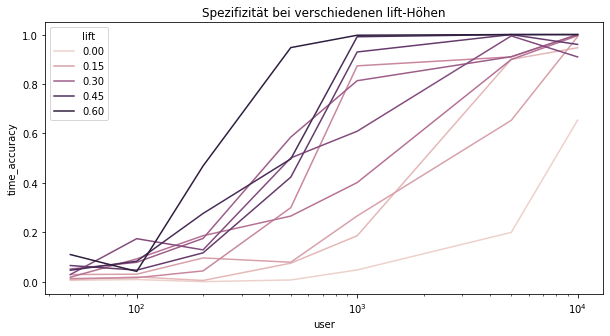

In [168]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=data, x='user', y='time_accuracy', hue='lift' )
ax.set_title("Spezifizität bei verschiedenen lift-Höhen")
ax.set(xscale="log")

Text(0.5, 1.0, 'Spezifizität bei verschiedenen Zahlen von Messungen')

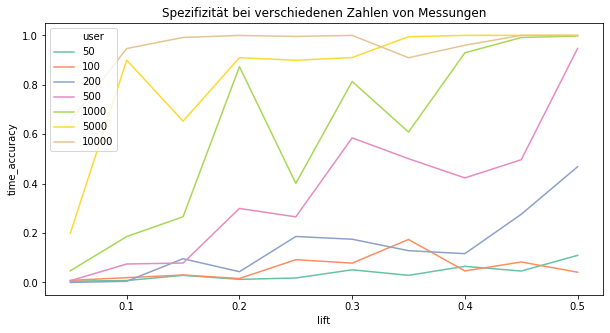

In [169]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=data, x='lift', y='time_accuracy', hue='user', palette='Set2' )
ax.set_title("Spezifizität bei verschiedenen Zahlen von Messungen")

In [159]:
# turn into heatmap
combined_df = pd.DataFrame()
for lift, dat in data.groupby('lift'):
    combined_df[np.round(lift,2)] = dat.set_index('user')['time_accuracy'].T

    

[Text(69.0, 0.5, 'Anzahl User'), Text(0.5, 24.0, 'Uplift')]

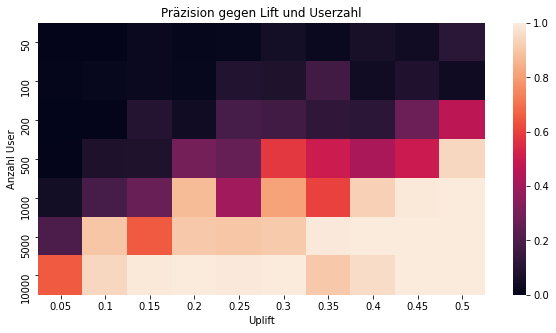

In [170]:
fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(data=combined_df)
ax.set_title("Präzision gegen Lift und Userzahl")
ax.set(xlabel='Uplift', ylabel='Anzahl User')

In [173]:
df = dataframe

In [181]:
# square error of l1 and l2 vs true values
df['l1delta'] = np.sqrt((df.l1 - 0.1 )**2 )
df['l2delta'] = np.sqrt((df.l2 - ( 0.1 + df.lift ) )**2 )

In [185]:
# remove broken analytics
df.loc[df.l1delta > 0.5, 'l1delta'] = None


Text(0.5, 1.0, 'Spezifizität bei verschiedenen Zahlen von Messungen')

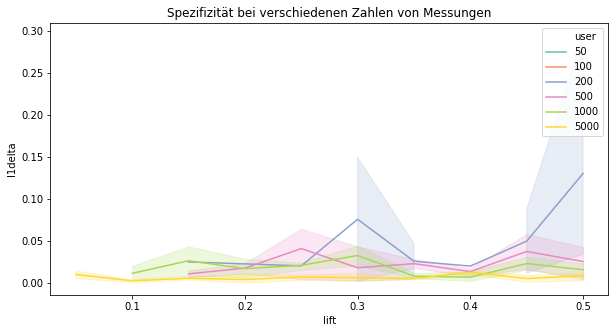

In [186]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=df, x='lift', y='l1delta', hue='user', palette='Set2' )
ax.set_title("Spezifizität bei verschiedenen Zahlen von Messungen")

Text(0.5, 1.0, 'Spezifizität bei verschiedenen Zahlen von Messungen')

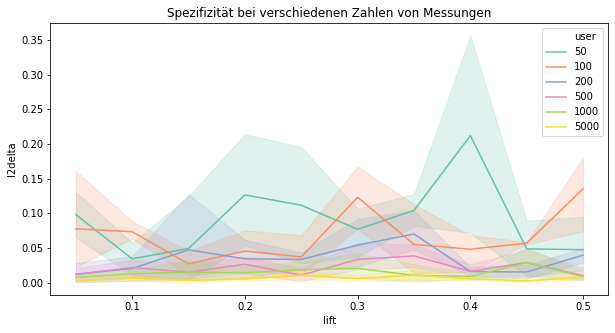

In [187]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=df, x='lift', y='l2delta', hue='user', palette='Set2' )
ax.set_title("Spezifizität bei verschiedenen Zahlen von Messungen")

In [ ]:
combined = {}
combined_df = pd.DataFrame()
for lift, dat in data.groupby('lift'):
    combined_df[np.round(lift,2)] = dat.set_index('user')['time_accuracy'].T
    #print(dat.set_index('user')['time_accuracy'].T )
    
fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(data=combined_df)
ax.set_title("Präzision gegen Lift und Userzahl")
ax.set(xlabel='Uplift', ylabel='Anzahl User')

In [189]:
data_l1 = pd.DataFrame(df.groupby(['lift','user'])['l1delta'].mean())
data_l1 = data_l1.reset_index()

In [191]:
combined_df = pd.DataFrame()
for lift, dat in data_l1.groupby('lift'):
    combined_df[np.round(lift,2)] = dat.set_index('user')['l1delta'].T


[Text(69.0, 0.5, 'Anzahl User'), Text(0.5, 24.0, 'Uplift')]

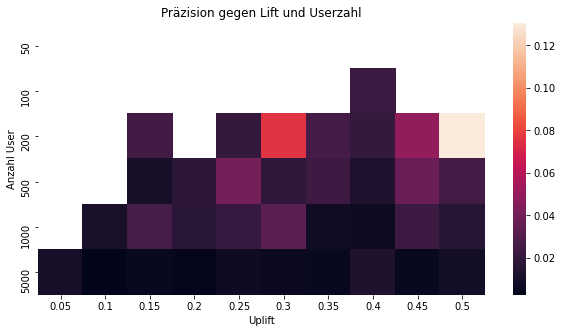

In [192]:
fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(data=combined_df)
ax.set_title("Präzision gegen Lift und Userzahl")
ax.set(xlabel='Uplift', ylabel='Anzahl User')